In [1]:
#| default_exp training

In [1]:
#|export
# import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import pickle,gzip,math,os,time,shutil,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt

from pathlib import Path
# from torch import tensor,nn
# import torch.nn.functional as F

import jax
import jax.numpy as jnp
import flax.linen as nn
from jax.scipy import special
from optax import losses

from cytoolz import partition_all
from tqdm.auto import tqdm

In [2]:
from fastcore.test import test_close

# torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
# torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
# x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])
x_train, y_train, x_valid, y_valid = map(jnp.array, [x_train, y_train, x_valid, y_valid])

2024-05-10 09:14:25.591740: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Initial setup

### Data

In [3]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [4]:
class Model(nn.Module):   
    n_in: int
    nh: int
    n_out: int

    def setup(self):
        self.layers = [nn.Dense(self.nh), nn.relu, nn.Dense(self.n_out)]

    
    # def __init__(self, n_in, nh, n_out):
    #     super().__init__()
        # self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]

        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [5]:
model = Model(m, nh, n_out=10)
key = jax.random.key(42)
params = model.init(key, x_train)
pred = model.apply(params, x_train)
# pred = model(x_train)
pred.shape

(50000, 10)

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [6]:
# def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()
def log_softmax(x): return jnp.log((jnp.exp(x)/(jnp.sum(jnp.exp(x), axis=-1, keepdims=True))))

In [7]:
smx = log_softmax(pred)
print(smx)
del smx

[[-2.7616212 -2.4488273 -2.3964708 ... -2.1585255 -2.4422033 -2.0649405]
 [-2.6426332 -2.229197  -2.151103  ... -2.5405574 -2.2871442 -2.5302484]
 [-2.2792363 -2.4974546 -2.168021  ... -2.482406  -2.3646762 -2.6438835]
 ...
 [-2.2595613 -2.4760604 -2.346009  ... -2.1632507 -2.2752864 -2.2968078]
 [-2.531205  -2.5598724 -2.1569514 ... -2.232909  -2.396523  -2.3275523]
 [-2.3378534 -2.5673983 -2.0652215 ... -2.4250243 -2.3522823 -2.3984969]]


Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax:

In [8]:
# def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()
def log_softmax(x): return x - jnp.log(jnp.sum(jnp.exp(x), axis=-1, keepdims=True))

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [9]:
def logsumexp(x):
    m = jnp.max(x, axis=-1)
    # return m + (x-m[:,None]).exp().sum(-1).log()
    return m + jnp.log(jnp.sum(jnp.exp(x-m[:,None]), axis=-1))

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [10]:
def log_softmax(x): return x - special.logsumexp(x, axis=-1, keepdims=True)

In [11]:
test_close(logsumexp(pred), special.logsumexp(pred, axis=-1))
sm_pred = log_softmax(pred)
sm_pred

Array([[-2.7616215, -2.4488275, -2.3964708, ..., -2.1585257, -2.4422035,
        -2.0649405],
       [-2.642633 , -2.2291968, -2.1511028, ..., -2.5405571, -2.2871437,
        -2.5302482],
       [-2.2792363, -2.4974546, -2.168021 , ..., -2.482406 , -2.3646762,
        -2.6438832],
       ...,
       [-2.2595615, -2.4760606, -2.3460093, ..., -2.1632507, -2.2752864,
        -2.2968078],
       [-2.531205 , -2.5598726, -2.1569514, ..., -2.232909 , -2.3965232,
        -2.3275523],
       [-2.3378534, -2.5673983, -2.0652215, ..., -2.4250243, -2.3522823,
        -2.3984969]], dtype=float32)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [12]:
y_train[:3]

Array([5, 0, 4], dtype=int32)

In [13]:
sm_pred[0,5],sm_pred[1,0],sm_pred[2,4]

(Array(-2.2299705, dtype=float32),
 Array(-2.642633, dtype=float32),
 Array(-2.2255213, dtype=float32))

In [14]:
sm_pred[[0,1,2], y_train[:3]]

Array([-2.2299705, -2.642633 , -2.2255213], dtype=float32)

In [15]:
# def nll(input, target): return -input[range(target.shape[0]), target].mean()
def nll(input, target): return -jnp.mean(input.at[:target.shape[0], target].get())

In [16]:
# sm_pred.at(range(y_train.shape[0]), 

In [17]:
sm_pred.at[:2, y_train].get()

Array([[-2.2299705, -2.7616215, -2.1726105, ..., -2.4422035, -2.1726105,
        -2.4422035],
       [-2.3071775, -2.642633 , -1.9782999, ..., -2.2871437, -1.9782999,
        -2.2871437]], dtype=float32)

In [18]:
# loss = nll(sm_pred, y_train)
# loss

loss = []
for p, true in tqdm(zip(partition_all(5_000, sm_pred), partition_all(5_000, y_train))):
    loss.append(nll(jnp.stack(p), jnp.stack(true)))
    del p, true
loss = jnp.mean(jnp.array(loss))
loss

0it [00:00, ?it/s]

Array(2.3271935, dtype=float32)

Then use PyTorch's implementation.

In [19]:
# test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [20]:
jnp.mean(losses.softmax_cross_entropy_with_integer_labels(pred, y_train))

Array(2.3554947, dtype=float32)

In [21]:
from optax import softmax_cross_entropy_with_integer_labels

In [22]:
jnp.mean(softmax_cross_entropy_with_integer_labels(pred, y_train))

Array(2.3554947, dtype=float32)

In [23]:
np.mean(softmax_cross_entropy_with_integer_labels(pred, y_train)), loss

(Array(2.3554947, dtype=float32), Array(2.3271935, dtype=float32))

In [24]:
# test_close(F.cross_entropy(pred, y_train), loss, 1e-3)
test_close(jnp.mean(softmax_cross_entropy_with_integer_labels(pred, y_train)), loss, 1e-3)

AssertionError: close:
2.355494737625122
2.32719349861145

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [25]:
# loss_func = F.cross_entropy
loss_func = softmax_cross_entropy_with_integer_labels

In [26]:
bs=50                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
# preds = model(xb)      # predictions
preds = model.apply(params, xb)
preds[0], preds.shape

(Array([-0.45370492, -0.14091104, -0.08855445,  0.03231215,  0.1353058 ,
         0.07794579,  0.06304041,  0.14939064, -0.1342871 ,  0.2429759 ],      dtype=float32),
 (50, 10))

In [27]:
yb = y_train[0:bs]
yb

Array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3], dtype=int32)

In [28]:
loss_func(preds, yb)

Array([2.2299705, 2.642633 , 2.2255213, 2.576247 , 2.4146516, 2.225658 ,
       2.3225238, 2.356748 , 2.3506737, 2.0716798, 2.2000601, 2.2572718,
       2.0863912, 2.7246022, 2.4060407, 2.5091004, 2.2461243, 2.4645007,
       2.6515172, 2.3453064, 2.33957  , 2.8971386, 2.3907444, 2.5407145,
       2.55032  , 2.1285377, 2.2201312, 2.1550813, 2.4150817, 2.2604208,
       2.3592186, 2.2590723, 2.573631 , 2.2131736, 2.7940185, 2.0177536,
       2.5907516, 2.8610444, 2.2017884, 2.7423017, 2.3397846, 2.3395984,
       2.586595 , 2.192431 , 2.2054746, 2.3544729, 2.3593862, 2.0810244,
       2.228127 , 2.3452876], dtype=float32)

In [29]:
jnp.mean(loss_func(preds, yb))

Array(2.376998, dtype=float32)

In [30]:
# preds.argmax(dim=1)
jnp.argmax(preds, axis=1)

Array([9, 4, 5, 4, 4, 4, 7, 4, 5, 5, 2, 7, 2, 4, 2, 5, 5, 4, 5, 2, 5, 4,
       4, 4, 5, 4, 5, 9, 3, 4, 5, 4, 4, 5, 4, 5, 5, 4, 4, 4, 5, 7, 5, 4,
       4, 4, 2, 5, 7, 9], dtype=int32)

In [31]:
#|export
# def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()
def accuracy(out, yb): return jnp.mean(jnp.argmax(out, axis=1) == yb)

In [32]:
accuracy(preds, yb)

Array(0.04, dtype=float32)

In [33]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for

In [34]:
#|export
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [35]:
xb,yb = x_train[:bs],y_train[:bs]
# preds = model(xb)
preds = model.apply(params, xb)
# report(loss_func(preds, yb), preds, yb)
report(jnp.mean(loss_func(preds, yb)), preds, yb)

2.38, 0.04


In [36]:
# def loss(model, params, inputs):

In [37]:
def l_fn(pred, true):
    return jnp.mean(loss_func(pred, true))

In [38]:
from cytoolz import curry
get_grads = jax.grad(l_fn)

In [39]:
get_grads(preds, yb)

Array([[ 0.00126378,  0.0017279 ,  0.00182077,  0.0020547 ,  0.0022776 ,
        -0.01784937,  0.00211881,  0.00230991,  0.00173938,  0.00253652],
       [-0.01857653,  0.0021523 ,  0.00232712,  0.00190433,  0.00276608,
         0.00199084,  0.00223551,  0.00157645,  0.00203112,  0.00159279],
       [ 0.00204725,  0.00164588,  0.00228808,  0.00219581, -0.01783978,
         0.00287849,  0.00181215,  0.00167084,  0.00187959,  0.00142169],
       [ 0.00195763, -0.01847882,  0.00207379,  0.00193786,  0.00257795,
         0.0016266 ,  0.00231283,  0.00221074,  0.00166783,  0.00211359],
       [ 0.00178956,  0.00164998,  0.0021288 ,  0.00173376,  0.00247667,
         0.00235406,  0.00236586,  0.00183212,  0.00188125, -0.01821203],
       [ 0.00146661,  0.00127838, -0.01784007,  0.00187929,  0.00284169,
         0.00204141,  0.00232544,  0.00229887,  0.0017451 ,  0.00196328],
       [ 0.00138673, -0.01803948,  0.0023345 ,  0.00165702,  0.00226941,
         0.00233998,  0.00189701,  0.0023853 

In [ ]:
# for epoch in range(epochs):
#     for i in range(0, n, bs):
#         s = slice(i, min(n,i+bs))
#         xb,yb = x_train[s],y_train[s]
#         preds = model(xb)
#         loss = loss_func(preds, yb)

#         # have to do backward pass
#         loss.backward()
#         with torch.no_grad():
#             for l in model.layers:
#                 if hasattr(l, 'weight'):
#                     l.weight -= l.weight.grad * lr
#                     l.bias   -= l.bias.grad   * lr
#                     l.weight.grad.zero_()
#                     l.bias  .grad.zero_()
#     report(loss, preds, yb)

In [40]:
def get_loss_model(model, params, features, y_true):
    preds = model.apply(params, features)
    loss = jnp.mean(loss_func(preds, y_true))
    return loss, preds

glm = curry(get_loss_model, model)
    
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb, yb = x_train[s], y_train[s]
        
        # (loss, preds), grads = jax.value_and_grad(glm, argnums=0, has_aux=True)(params, xb, yb)  
        (loss, preds), grads = jax.value_and_grad(glm, argnums=0, has_aux=True)(params, xb, yb)     


        # grads are equivalent to loss.backward
        for layer_key in grads['params'].keys():
            for k,v in grads['params'][layer_key].items():
                params['params'][layer_key][k] -= v * lr
                
    report(loss, preds, yb)

0.20, 0.86
0.18, 0.94
0.14, 0.92


## Using parameters and optim

### Parameters

In [43]:
# m1 = nn.Module()
# m1.foo = nn.Linear(3,4)

class Model(nn.Module):
    inp: int
    opt: int

    def setup(self):
        self.m1 = nn.Dense(self.opt)

    def __call__(self, x):
        return self.m1(x)
        
m1 = Model(3, 4)
key = jax.random.key(42)
params = model.init(key, x_train)

In [44]:
print(m1.tabulate(key, xb, compute_flops=True, compute_vjp_flops=True))


                                 Model Summary                                  
┏━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ path ┃ module ┃ inputs      ┃ outputs     ┃ flops  ┃ vjp_flops ┃ params      ┃
┡━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│      │ Model  │ float32[50… │ float32[50… │ 313800 │ 944336    │             │
├──────┼────────┼─────────────┼─────────────┼────────┼───────────┼─────────────┤
│ m1   │ Dense  │ float32[50… │ float32[50… │ 313800 │ 944336    │ bias:       │
│      │        │             │             │        │           │ float32[4]  │
│      │        │             │             │        │           │ kernel:     │
│      │        │             │             │        │           │ float32[78… │
│      │        │             │             │        │           │             │
│      │        │             │             │        │           │ 3,140 (12.6 │
│      │        │          

In [45]:
# list(m1.named_children())

In [46]:
# m1.named_children()

In [47]:
# list(m1.parameters())
params

{'params': {'layers_0': {'kernel': Array([[ 0.00084758,  0.06064403, -0.06266869, ..., -0.00681735,
           -0.00187519, -0.02079083],
          [-0.01123159,  0.00575195,  0.03618244, ...,  0.01979761,
           -0.01443758, -0.00126234],
          [ 0.00869545, -0.00858875,  0.06376506, ..., -0.01492844,
           -0.0450354 ,  0.03631166],
          ...,
          [-0.03845134, -0.00953184, -0.04398863, ...,  0.02352371,
            0.06378859, -0.0080379 ],
          [ 0.04453897, -0.01387933, -0.03332501, ..., -0.07309227,
            0.02147802,  0.01484199],
          [ 0.01643012, -0.03393842,  0.05047164, ...,  0.01506289,
            0.07461423, -0.01509868]], dtype=float32),
   'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)},
  'layers_2': {'kernel': Array([[ 1.351

In [48]:
import flax

In [49]:
class MLP(nn.Module):
    n_in: int
    nh: int
    n_out: int
    
    # def __init__(self, n_in, nh, n_out):
    #     super().__init__()
    #     self.l1 = nn.Linear(n_in,nh)
    #     self.l2 = nn.Linear(nh,n_out)
    #     self.relu = nn.ReLU()

    def setup(self):
        self.l1 = nn.Dense(self.nh)
        self.l2 = nn.Dense(self.n_out)
        # self.relu = flax.linen.relu()
        
    # def forward(self, x): return self.l2(self.relu(self.l1(x)))
    def __call__(self, x): return self.l2(nn.relu(self.l1(x)))

In [50]:
model = MLP(m, nh, 10)
params = model.init(jax.random.key(42), x_train)
# model.l1

In [51]:
model

MLP(
    # attributes
    n_in = 784
    nh = 50
    n_out = 10
)

In [52]:
# for name,l in model.named_children(): print(f"{name}: {l}")
print(model.tabulate(key, xb, compute_flops=True, compute_vjp_flops=True))


                                  MLP Summary                                   
┏━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ path ┃ module ┃ inputs      ┃ outputs    ┃ flops   ┃ vjp_flops ┃ params      ┃
┡━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│      │ MLP    │ float32[50… │ float32[5… │ 3975500 │ 11963200  │             │
├──────┼────────┼─────────────┼────────────┼─────────┼───────────┼─────────────┤
│ l1   │ Dense  │ float32[50… │ float32[5… │ 3922500 │ 11804200  │ bias:       │
│      │        │             │            │         │           │ float32[50] │
│      │        │             │            │         │           │ kernel:     │
│      │        │             │            │         │           │ float32[78… │
│      │        │             │            │         │           │             │
│      │        │             │            │         │           │ 39,250      │
│      │        │          

In [53]:
# for p in model.parameters(): print(p.shape)
jax.tree_util.tree_map(jnp.shape, params)

{'params': {'l1': {'bias': (50,), 'kernel': (784, 50)},
  'l2': {'bias': (10,), 'kernel': (50, 10)}}}

In [54]:
def fit(jax_fw_pass, params):
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            
        #     preds = model(xb)
        #     loss = loss_func(preds, yb)
        #     loss.backward()
        #     with torch.no_grad():
        #         for p in model.parameters(): p -= p.grad * lr
        #         model.zero_grad()
        # report(loss, preds, yb)

        (loss, preds), grads = jax.value_and_grad(jax_fw_pass, argnums=0, has_aux=True)(params, xb, yb)     


        # grads are equivalent to loss.backward
        for layer_key in grads['params'].keys():
            for k,v in grads['params'][layer_key].items():
                params['params'][layer_key][k] -= v * lr
                    
        report(loss, preds, yb)

In [55]:
jax_fw_pass = curry(get_loss_model, model)

In [56]:
# fit()
fit(jax_fw_pass, params)

2.35, 0.08
1.97, 0.42
1.60, 0.78


###### Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

### In JAX this isn't strictly true since parameters exist outside the model and are therefore not registered into the class.

In [57]:
# class MyModule:
#     def __init__(self, n_in, nh, n_out):
#         self._modules = {}
#         self.l1 = nn.Linear(n_in,nh)
#         self.l2 = nn.Linear(nh,n_out)

#     def __setattr__(self,k,v):
#         if not k.startswith("_"): self._modules[k] = v
#         super().__setattr__(k,v)

#     def __repr__(self): return f'{self._modules}'
    
#     def parameters(self):
#         for l in self._modules.values(): yield from l.parameters()

In [58]:
# mdl = MyModule(m,nh,10)
# mdl

In [59]:
# for p in mdl.parameters(): print(p.shape)

### Registering modules

In [60]:
from functools import reduce

We can use the original `layers` approach, but we have to register the modules.

In [61]:
# layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]
layers = [nn.Dense(nh), nn.relu, nn.Dense(10)]

In [62]:
from cytoolz import thread_first

In [63]:
# class Model(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.layers = layers
#         for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

#     def forward(self, x): return reduce(lambda val,layer: layer(val), self.layers, x)

In [64]:
# model = Model(layers)
# model

In [65]:
# model(xb).shape

### nn.ModuleList

`nn.ModuleList` does this for us.

In [66]:
class SequentialModel(nn.Module):
    inp_layers: list

    def setup(self):
        self.layers = self.inp_layers
        
    # def __init__(self, layers):
    #     super().__init__()
    #     self.layers = nn.ModuleList(layers)
        
    # def forward(self, x):
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [67]:
# class SequentialModel(nn.Module):
#     layers: list
        
#     def __call__(self, x):
#         for l in self.layers: x = l(x)
#         return x

In [68]:
model = SequentialModel(layers)
model

SequentialModel(
    # attributes
    inp_layers = [Dense(
        # attributes
        features = 50
        use_bias = True
        dtype = None
        param_dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
        dot_general = None
        dot_general_cls = None
    ), <jax._src.custom_derivatives.custom_jvp object at 0x74a59d64ec20>, Dense(
        # attributes
        features = 10
        use_bias = True
        dtype = None
        param_dtype = float32
        precision = None
        kernel_init = init
        bias_init = zeros
        dot_general = None
        dot_general_cls = None
    )]
)

In [69]:
# nn.Sequential(layers)

In [70]:
params = model.init(jax.random.key(42), x_train)

In [71]:
jax_fw_pass = curry(get_loss_model, model)

In [72]:
fit(jax_fw_pass, params)

2.32, 0.10
1.88, 0.50
1.52, 0.68


### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [73]:
# model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [74]:
class Model(nn.Module):
    nh: int
    
    @nn.compact
    def __call__(self, x):
        return thread_first(
            x,
            nn.Dense(nh), 
            nn.relu, 
            nn.Dense(10),
        )

model = Model(nh)
params = model.init(jax.random.key(42), xb)

In [75]:
# fit()
jax_fw_pass = curry(get_loss_model, model)
fit(jax_fw_pass, params)
# loss_func(model(xb), yb), accuracy(model(xb), yb)
loss_func(model.apply(params, xb), yb), accuracy(model.apply(params, xb), yb)

2.32, 0.08
1.96, 0.52
1.58, 0.66


(Array([0.84741366, 0.74000174, 0.5388808 , 0.36210084, 0.8273415 ,
        1.6482549 , 0.711874  , 1.0429876 , 1.8101919 , 0.74176687,
        1.8879099 , 2.257093  , 0.56879216, 1.844775  , 2.263823  ,
        0.564728  , 1.6968277 , 1.3402851 , 1.765891  , 0.58509743,
        1.036983  , 0.4104269 , 2.1872613 , 0.99904   , 0.71518445,
        0.7481323 , 0.5691101 , 0.70057935, 1.572373  , 1.8575803 ,
        1.5375795 , 1.4306394 , 1.2342105 , 1.1522068 , 0.8590653 ,
        1.725537  , 1.8949713 , 1.4486787 , 1.3742487 , 0.79983455,
        1.8367733 , 0.922026  , 1.1009822 , 0.6674258 , 1.2506173 ,
        0.66259664, 0.8287465 , 2.1102612 , 1.5048342 , 1.70374   ],      dtype=float32),
 Array(0.7, dtype=float32))

In [76]:
# model

### optim

In [77]:
class Optimizer():
    # def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
    def __init__(self, params, lr=0.5): self.params,self.lr=params,lr


    def step(self, grads):
        # with torch.no_grad():
        #     for p in self.params: p -= p.grad * self.lr

        # grads are equivalent to loss.backward
        for layer_key in grads['params'].keys():
            for k,v in grads['params'][layer_key].items():
                self.params['params'][layer_key][k] -= v * lr

    # no need to zero grads
    # def zero_grad(self):
    #     for p in self.params: p.grad.data.zero_()

In [78]:
# model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [79]:
# opt = Optimizer(model.parameters())
opt = Optimizer(params)

In [80]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]

        # preds = model(xb)
        # loss = loss_func(preds, yb)
        # loss.backward()
        (loss, preds), grads = jax.value_and_grad(jax_fw_pass, argnums=0, has_aux=True)(params, xb, yb)     

        # opt.step()
        opt.step(grads)
        # opt.zero_grad()
    report(loss, preds, yb)

0.16, 0.98
0.11, 0.98
0.09, 0.96


PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later)

In [81]:
# from torch import optim

In [82]:
# def get_model():
#     model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
#     return model, optim.SGD(model.parameters(), lr=lr)

def get_model(nh=nh, xb=xb, lr=lr):
    model = model = Model(nh)
    params = model.init(jax.random.key(42), xb)
    opt = optax.sgd(learning_rate=lr)
    opt_state = opt.init(params)
    return (model, params), (opt, opt_state)

In [83]:
# model,opt = get_model()
# loss_func(model(xb), yb)

In [84]:
# for epoch in range(epochs):
#     for i in range(0, n, bs):
#         s = slice(i, min(n,i+bs))
#         xb,yb = x_train[s],y_train[s]
#         preds = model(xb)
#         loss = loss_func(preds, yb)
#         loss.backward()
#         opt.step()
#         opt.zero_grad()
#     report(loss, preds, yb)

In [85]:
import optax

In [86]:
opt = optax.sgd(learning_rate=lr)
opt_state = opt.init(params)

In [87]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        (loss, preds), grads = jax.value_and_grad(jax_fw_pass, argnums=0, has_aux=True)(params, xb, yb)     
        updates, opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
    report(loss, preds, yb)

0.06, 0.98
0.05, 0.98
0.04, 0.98


## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[s]
    yb = y_train[s]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[s]
```

In [88]:
#|export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [89]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [90]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(Array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 Array([5, 0, 4, 1, 9], dtype=int32))

In [91]:
model,opt = get_model()

In [92]:
# for epoch in range(epochs):
#     for i in range(0, n, bs):
#         xb,yb = train_ds[i:min(n,i+bs)]
#         preds = model(xb)
#         loss = loss_func(preds, yb)
#         loss.backward()
#         opt.step()
#         opt.zero_grad()
#     report(loss, preds, yb)

model, params = model
opt, opt_state = opt
jax_fw_pass = jax_fw_pass = curry(get_loss_model, model)


for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        (loss, preds), grads = jax.value_and_grad(jax_fw_pass, argnums=0, has_aux=True)(params, xb, yb)     
        updates, opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
    report(loss, preds, yb)

0.15, 0.96
0.08, 0.98
0.09, 0.96


### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [93]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [94]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [95]:
xb,yb = next(iter(valid_dl))
xb.shape

(50, 784)

In [96]:
yb

Array([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7,
       4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
       8, 3, 7, 7, 8, 4], dtype=int32)

Array(3, dtype=int32)

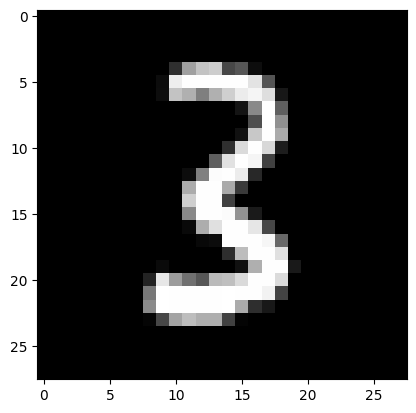

In [97]:
# plt.imshow(xb[0].view(28,28))
plt.imshow(jnp.reshape(xb[0], (28,28)))
yb[0]

In [98]:
model,opt = get_model()

In [99]:
# def fit():
#     for epoch in range(epochs):
#         for xb,yb in train_dl:
#             preds = model(xb)
#             loss = loss_func(preds, yb)
#             loss.backward()
#             opt.step()
#             opt.zero_grad()
#         report(loss, preds, yb)

def fit(model, opt):
    model, params = model
    opt, opt_state = opt
    jax_fw_pass = curry(get_loss_model, model)

    
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            (loss, preds), grads = jax.value_and_grad(jax_fw_pass, argnums=0, has_aux=True)(params, xb, yb)     
            updates, opt_state = opt.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
        report(loss, preds, yb)

    return model, params

In [100]:
# fit()
# loss_func(model(xb), yb), accuracy(model(xb), yb)

model, params = fit(model, opt)
loss_func(model.apply(params, xb), yb), accuracy(model.apply(params, xb), yb)

0.15, 0.96
0.08, 0.98
0.09, 0.96


(Array([4.02369595e-04, 2.97556235e-03, 1.20990109e-04, 8.19942856e-04,
        4.24507959e-03, 1.01011658e+00, 4.05613407e-02, 7.03583751e-03,
        5.26778772e-03, 5.85871823e-02, 3.69541958e-05, 3.11683718e-04,
        3.12323464e-05, 6.53768424e-04, 1.29762515e-02, 1.53114344e-03,
        6.95344410e-04, 3.12911137e-03, 6.03180815e-05, 5.73351514e-04,
        2.31725331e-02, 1.99401565e-02, 3.35939066e-03, 1.49055442e-03,
        3.29974666e-03, 2.63593579e-03, 1.11931258e-04, 3.06279818e-03,
        3.04929148e-02, 2.01189313e-02, 8.59487162e-04, 7.48354243e-04,
        8.17798893e-04, 1.23363798e-02, 8.17742257e-05, 4.69949516e-03,
        6.46093467e-05, 3.20059322e-02, 1.34544424e-03, 1.14791954e-04,
        2.85140481e-02, 1.07024297e-01, 3.21864559e-06, 2.35965420e-02,
        5.45951771e-03, 1.10981846e-03, 9.79221314e-02, 1.81589760e-02,
        2.74581388e-02, 5.32841869e-02], dtype=float32),
 Array(0.97999996, dtype=float32))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [101]:
import random

In [102]:
class Sampler():
    def __init__(self, ds, shuffle=False): self.n,self.shuffle = len(ds),shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [103]:
from itertools import islice

In [104]:
ss = Sampler(train_ds)

In [105]:
it = iter(ss)
for o in range(5): print(next(it))

0
1
2
3
4


In [106]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [107]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[48525, 41912, 24600, 14957, 8632]

In [108]:
import fastcore.all as fc

In [109]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [110]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[41561, 8784, 24004, 46171],
 [18139, 26628, 33037, 44230],
 [16891, 34846, 10539, 19187],
 [33371, 48671, 29803, 10264],
 [15176, 18463, 6270, 48561]]

In [111]:
def collate(b):
    xs,ys = zip(*b)
    return jnp.stack(xs),jnp.stack(ys)

In [112]:
import torch

In [113]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [114]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [115]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

Array(3, dtype=int32)

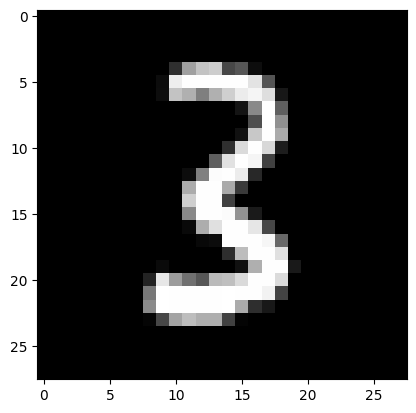

In [116]:
xb,yb = next(iter(valid_dl))
# plt.imshow(xb[0].view(28,28))
plt.imshow(jnp.reshape(xb[0], (28,28)))
yb[0]

In [117]:
xb.shape,yb.shape

((50, 784), (50,))

In [118]:
model,opt = get_model()

In [119]:
fit(model, opt)

0.15, 0.96
0.08, 0.98
0.09, 0.96


(Model(
     # attributes
     nh = 50
 ),
 {'params': {'Dense_0': {'bias': Array([-0.15659213,  0.0802639 , -0.1906464 , -0.04901754, -0.5133901 ,
           -0.08605969,  0.05876019,  0.04231644, -0.01707657,  0.15483388,
            0.1236347 ,  0.3917885 ,  0.00687274, -0.20486538,  0.12158427,
            0.5108256 ,  0.25512758, -0.27549705,  0.31419104,  0.04536387,
           -0.0366312 , -0.03733613,  0.11489447,  0.54547477, -0.21809979,
           -0.11544421, -0.09879699, -0.0822797 , -0.07752538, -0.07340132,
           -0.5137772 , -0.41313404,  0.00544193,  0.06640723,  0.03280573,
           -0.07977369,  0.04062178,  0.01304291, -0.03443436, -0.22928455,
           -0.04526258,  0.3229372 ,  0.0637643 , -0.06092556, -0.04624177,
           -0.10067464, -0.10254364,  0.4358636 ,  0.02602702, -0.17212023],      dtype=float32),
    'kernel': Array([[-0.01414529, -0.00688224,  0.0536295 , ..., -0.00789963,
            -0.03173989,  0.0042826 ],
           [ 0.04734543,  0.

### Multiprocessing DataLoader

In [120]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [123]:
train_ds[jnp.array([3,6,8,1])]

(Array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 Array([1, 1, 1, 0], dtype=int32))

In [124]:
train_ds.__getitem__(jnp.array([3,6,8,1]))

(Array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 Array([1, 1, 1, 0], dtype=int32))

In [125]:
for o in map(train_ds.__getitem__, (jnp.array([[3,6],[8,1]]))): print(o)
# list(map(lambda o: train_ds.__getitem__(o), [3, 6, 8, 1]))

(Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), Array([1, 1], dtype=int32))
(Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), Array([1, 0], dtype=int32))


In [126]:
from cytoolz.curried import compose_left

In [127]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(
            compose_left(
                jnp.array,
                self.ds.__getitem__, 
            ),
            iter(self.batchs)
        )

In [128]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [130]:
# this cell crashes in jax because jax already multithreaded
# xb,yb = next(it)
# xb.shape,yb.shape

### PyTorch DataLoader

In [131]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [132]:
train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [133]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [134]:
model,opt = get_model()
# fit()
# loss_func(model(xb), yb), accuracy(model(xb), yb)

model, params = fit(model, opt)
loss_func(model.apply(params, xb), yb), accuracy(model.apply(params, xb), yb)

0.15, 0.96
0.08, 0.98
0.09, 0.96


(Array([4.02369595e-04, 2.97556235e-03, 1.20990109e-04, 8.19942856e-04,
        4.24507959e-03, 1.01011658e+00, 4.05613407e-02, 7.03583751e-03,
        5.26778772e-03, 5.85871823e-02, 3.69541958e-05, 3.11683718e-04,
        3.12323464e-05, 6.53768424e-04, 1.29762515e-02, 1.53114344e-03,
        6.95344410e-04, 3.12911137e-03, 6.03180815e-05, 5.73351514e-04,
        2.31725331e-02, 1.99401565e-02, 3.35939066e-03, 1.49055442e-03,
        3.29974666e-03, 2.63593579e-03, 1.11931258e-04, 3.06279818e-03,
        3.04929148e-02, 2.01189313e-02, 8.59487162e-04, 7.48354243e-04,
        8.17798893e-04, 1.23363798e-02, 8.17742257e-05, 4.69949516e-03,
        6.46093467e-05, 3.20059322e-02, 1.34544424e-03, 1.14791954e-04,
        2.85140481e-02, 1.07024297e-01, 3.21864559e-06, 2.35965420e-02,
        5.45951771e-03, 1.10981846e-03, 9.79221314e-02, 1.81589760e-02,
        2.74581388e-02, 5.32841869e-02], dtype=float32),
 Array(0.97999996, dtype=float32))

PyTorch can auto-generate the BatchSampler for us:

In [155]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

PyTorch can also generate the Sequential/RandomSamplers too:

In [153]:
# # NO MULTIPROCESSING ATOP JAX!
# train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
# valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [137]:
model,opt = get_model()
# fit()

# loss_func(model(xb), yb), accuracy(model(xb), yb)

model, params = fit(model, opt)
loss_func(model.apply(params, xb), yb), accuracy(model.apply(params, xb), yb)

0.15, 0.96
0.08, 0.98
0.09, 0.96


(Array([4.02369595e-04, 2.97556235e-03, 1.20990109e-04, 8.19942856e-04,
        4.24507959e-03, 1.01011658e+00, 4.05613407e-02, 7.03583751e-03,
        5.26778772e-03, 5.85871823e-02, 3.69541958e-05, 3.11683718e-04,
        3.12323464e-05, 6.53768424e-04, 1.29762515e-02, 1.53114344e-03,
        6.95344410e-04, 3.12911137e-03, 6.03180815e-05, 5.73351514e-04,
        2.31725331e-02, 1.99401565e-02, 3.35939066e-03, 1.49055442e-03,
        3.29974666e-03, 2.63593579e-03, 1.11931258e-04, 3.06279818e-03,
        3.04929148e-02, 2.01189313e-02, 8.59487162e-04, 7.48354243e-04,
        8.17798893e-04, 1.23363798e-02, 8.17742257e-05, 4.69949516e-03,
        6.46093467e-05, 3.20059322e-02, 1.34544424e-03, 1.14791954e-04,
        2.85140481e-02, 1.07024297e-01, 3.21864559e-06, 2.35965420e-02,
        5.45951771e-03, 1.10981846e-03, 9.79221314e-02, 1.81589760e-02,
        2.74581388e-02, 5.32841869e-02], dtype=float32),
 Array(0.97999996, dtype=float32))

Our dataset actually already knows how to sample a batch of indices all at once:

In [138]:
# train_ds[[4,6,7]]
train_ds[jnp.array([4,6,7])]

(Array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 Array([9, 1, 3], dtype=int32))

...that means that we can actually skip the batch_sampler and collate_fn entirely:

In [142]:
# Not working in jax
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [143]:
# # not working - something in torch not doing the array lookup over a jnp.array of idx
# xb,yb = next(iter(train_dl))
# xb.shape,yb.shape

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [165]:
#|export

# def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
#     for epoch in range(epochs):
#         model.train()
#         for xb,yb in train_dl:
#             loss = loss_func(model(xb), yb)
#             loss.backward()
#             opt.step()
#             opt.zero_grad()

#         model.eval()
#         with torch.no_grad():
#             tot_loss,tot_acc,count = 0.,0.,0
#             for xb,yb in valid_dl:
#                 pred = model(xb)
#                 n = len(xb)
#                 count += n
#                 tot_loss += loss_func(pred,yb).item()*n
#                 tot_acc  += accuracy (pred,yb).item()*n
#         print(epoch, tot_loss/count, tot_acc/count)
#     return tot_loss/count, tot_acc/count


def get_loss_model(loss_func, model, params, features, y_true):
    preds = model.apply(params, features)
    loss = jnp.mean(loss_func(preds, y_true))
    return loss, preds
    

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    model, params = model
    opt, opt_state = opt
    jax_fw_pass = curry(get_loss_model, loss_func, model)
    
    for epoch in range(epochs):
        for xb, yb in train_dl:
            (loss, preds), grads = jax.value_and_grad(jax_fw_pass, argnums=0, has_aux=True)(params, xb, yb)     
            updates, opt_state = opt.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
        tot_loss, tot_acc, count = 0.,0.,0
        for xb, yb in valid_dl:
            pred = model.apply(params, xb)
            n = len(xb)
            count += n
            tot_loss += jnp.mean(loss_func(pred, yb))*n
            tot_acc += accuracy(pred, yb)*n
        print(epoch, tot_loss/count, tot_acc/count)

    return tot_loss/count, tot_acc/count

In [166]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, bs, shuffle=True, collate_fn=collate, **kwargs),
            DataLoader(valid_ds, bs*2, collate_fn=collate, **kwargs))

def collate(b):
    xs,ys = zip(*b)
    return jnp.stack(xs),jnp.stack(ys)

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [167]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()

In [ ]:
%time loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.14854692 0.9549


## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()